## Dynamic Pricing before Halloween

In [31]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

from dataclasses import dataclass
from typing import Iterator
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from rl.finite_horizon import (
    construct_finite_horizon_mdp,
    deconstruct_finite_horizon_mdp,
    construct_finite_horizon_mrp,
    deconstruct_finite_horizon_mrp,
    WithTime,
    compute_vf_at_each_time_step,
    calculate_optimal_vf_and_policies,
    VALUE_FUNCTION,
)
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.distributions import Categorical
from rl.policy import FiniteDeterministicPolicy, FinitePolicy
from rl.states import NonTerminal

In [3]:
@dataclass(frozen=True)
class Discount:
    amount: float


class ClearancePricingMDP:
    initial_inventory: int
    time_steps: int
    price_lambda_pairs: list[tuple[float, float]]
    single_step_mdp: FiniteMarkovDecisionProcess[int, int]
    mdp: FiniteMarkovDecisionProcess[WithTime[int], int]

    def __init__(
        self,
        initial_inventory: int,
        time_steps: int,
        price_lambda_pairs: list[tuple[float, float]],
    ):
        self.initial_inventory = initial_inventory
        self.time_steps = time_steps
        self.price_lambda_pairs = price_lambda_pairs

        distributions = [poisson(demand_rate) for _, demand_rate in price_lambda_pairs]
        prices = [price for price, _ in price_lambda_pairs]

        self.single_step_mdp: FiniteMarkovDecisionProcess[int, int] = (
            FiniteMarkovDecisionProcess(
                {
                    # today's inventory (current state) : {
                    #     price to set today (action) : distribution(
                    #         (
                    #             tomorrow's inventory (next state),
                    #             today's revenue generated from selling k items at prices[i] (reward)
                    #         ) : probability of units sold today (transition probability)
                    #     )
                    # }
                    current_inventory: {
                        Discount(np.round(1.0 - price, 1).item()): Categorical(
                            {
                                (current_inventory - demand, price * demand): (
                                    distribution.pmf(demand)
                                    if demand < current_inventory
                                    else 1.0 - distribution.cdf(current_inventory - 1)
                                )
                                for demand in range(current_inventory + 1)
                            }
                        )
                        for price, distribution in zip(prices, distributions)
                    }
                    for current_inventory in range(initial_inventory + 1)
                }
            )
        )

        self.mdp = construct_finite_horizon_mdp(
            process=self.single_step_mdp, limit=time_steps
        )

    def compute_vf_for_policy(
        self, policy: FinitePolicy[WithTime[int], int]
    ) -> Iterator[VALUE_FUNCTION[int]]:
        mrp = self.mdp.apply_finite_policy(policy=policy)
        return compute_vf_at_each_time_step(
            steps=deconstruct_finite_horizon_mrp(mrp),
            gamma=1.0,
        )

    def calculate_vf_policies(
        self,
    ) -> Iterator[tuple[VALUE_FUNCTION[int], FiniteDeterministicPolicy[int, int]]]:
        return calculate_optimal_vf_and_policies(
            steps=deconstruct_finite_horizon_mdp(process=self.mdp),
            gamma=1.0,
        )

In [4]:
initial_inventory = 12
time_steps = 8

price_demand_rate_pairs = [
    (1.0, 0.5),  # "full price"
    (0.7, 1.0),  # "30% off"
    (0.5, 1.5),  # "50% off"
    (0.3, 2.5),  # "70% off"
]

mdp = ClearancePricingMDP(
    initial_inventory=initial_inventory,
    time_steps=time_steps,
    price_lambda_pairs=price_demand_rate_pairs,
)

In [5]:
print(mdp.single_step_mdp)

From State 0:
  With Action Discount(amount=0.0):
    To [State 0 and Reward 0.000] with Probability 1.000
  With Action Discount(amount=0.3):
    To [State 0 and Reward 0.000] with Probability 1.000
  With Action Discount(amount=0.5):
    To [State 0 and Reward 0.000] with Probability 1.000
  With Action Discount(amount=0.7):
    To [State 0 and Reward 0.000] with Probability 1.000
From State 1:
  With Action Discount(amount=0.0):
    To [State 1 and Reward 0.000] with Probability 0.607
    To [State 0 and Reward 1.000] with Probability 0.393
  With Action Discount(amount=0.3):
    To [State 1 and Reward 0.000] with Probability 0.368
    To [State 0 and Reward 0.700] with Probability 0.632
  With Action Discount(amount=0.5):
    To [State 1 and Reward 0.000] with Probability 0.223
    To [State 0 and Reward 0.500] with Probability 0.777
  With Action Discount(amount=0.7):
    To [State 1 and Reward 0.000] with Probability 0.082
    To [State 0 and Reward 0.300] with Probability 0.918


### Implementing a Stationary Policy
Let us test the following policy (and see what the revenue generated with this policy is):
1. If the inventory < 2, offer "Full Price".
2. Otherwise, if the inventory < 5, offer "30% Off".
3. Otherwise, if the inventory < 8, offer "50% Off".
4. Otherwise, offer "70% Off".

In [ ]:
def policy_func(current_inventory: int) -> int:
    if current_inventory < 2:
        return Discount(amount=0.0)
    elif current_inventory < 5:
        return Discount(amount=0.3)
    elif current_inventory < 8:
        return Discount(amount=0.5)
    else:
        return Discount(amount=0.7)


stationary_policy = FiniteDeterministicPolicy(
    {
        current_inventory: policy_func(current_inventory=current_inventory)
        for current_inventory in range(initial_inventory + 1)
    }
)

single_step_mrp = mdp.single_step_mdp.apply_finite_policy(stationary_policy)

single_step_mrp

From State 0:
	To State 0 with Probability 1.000
From State 1:
	To State 1 with Probability 0.607
	To State 0 with Probability 0.393
From State 2:
	To State 2 with Probability 0.368
	To State 1 with Probability 0.368
	To State 0 with Probability 0.264
From State 3:
	To State 3 with Probability 0.368
	To State 2 with Probability 0.368
	To State 1 with Probability 0.184
	To State 0 with Probability 0.080
From State 4:
	To State 4 with Probability 0.368
	To State 3 with Probability 0.368
	To State 2 with Probability 0.184
	To State 1 with Probability 0.061
	To State 0 with Probability 0.019
From State 5:
	To State 5 with Probability 0.223
	To State 4 with Probability 0.335
	To State 3 with Probability 0.251
	To State 2 with Probability 0.126
	To State 1 with Probability 0.047
	To State 0 with Probability 0.019
From State 6:
	To State 6 with Probability 0.223
	To State 5 with Probability 0.335
	To State 4 with Probability 0.251
	To State 3 with Probability 0.126
	To State 2 with Probabilit

In [ ]:
outcomes_ = [
    (time, inventory, stationary_policy.act(state=NonTerminal(inventory)).value.amount)
    for time in range(time_steps)
    for inventory in range(initial_inventory + 1)
]

outcomes = (
    pd.DataFrame(outcomes_, columns=["Time", "Inventory", "Discount"])
    .pivot(
        index="Inventory",
        columns="Time",
        values="Discount",
    )
    .sort_index(ascending=False)
)

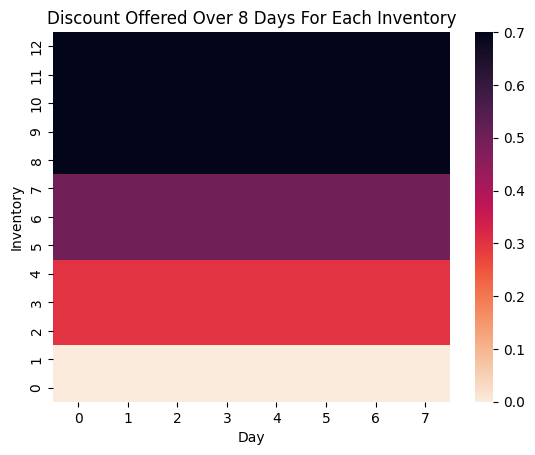

In [39]:
sns.heatmap(data=outcomes, cmap="rocket_r")

plt.title(f"Discount Offered Over {time_steps} Days For Each Inventory")
plt.xlabel("Day")

plt.show()

In [40]:
vf_for_stationary_policy = compute_vf_at_each_time_step(
    deconstruct_finite_horizon_mrp(
        process=construct_finite_horizon_mrp(
            process=single_step_mrp,
            limit=time_steps,
        )
    ),
    gamma=1.0,
)

In [ ]:
outcomes_ = [
    (time + 1, inventory.state, reward)
    for time, vf in enumerate(vf_for_stationary_policy)
    for inventory, reward in vf.items()
]

outcomes = (
    pd.DataFrame(outcomes_, columns=["Time", "Inventory", "Revenue"])
    .pivot(
        index="Inventory",
        columns="Time",
        values="Revenue",
    )
    .sort_index(ascending=False)
)

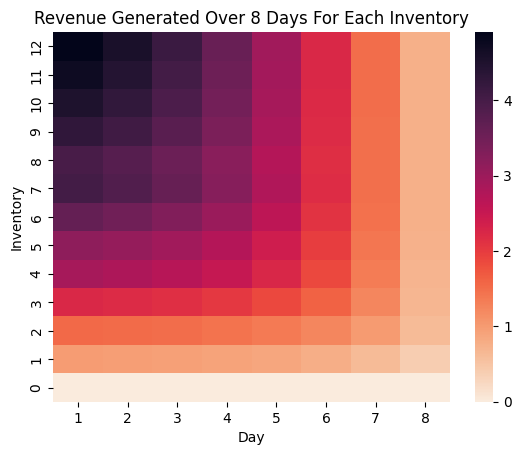

In [42]:
sns.heatmap(data=outcomes, cmap="rocket_r")

plt.title(f"Revenue Generated Over {time_steps} Days For Each Inventory")
plt.xlabel("Day")

plt.show()

### What is the Best Discount Policy?

In [43]:
optimal_vf_and_policies = list(mdp.calculate_vf_policies())

TypeError: tuple indices must be integers or slices, not NonTerminal